# 영업 성공 여부 분류 경진대회 

# 예시코드

In [153]:
!pip install xgboost
!pip install impyute
!pip install lightgbm
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [80]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from impyute.imputation.cs import mice
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [81]:
#데이터 로드
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)



# 무의미 피처 삭제

In [82]:
def remove_feature(df, col):
    df.drop(columns=col,inplace=True)
    return df

#1. customer_country1. 삭제
remove_feature(df_train,["customer_country.1"])
remove_feature(df_test,["customer_country.1"])

#2. product_subcategory 삭제
remove_feature(df_train,["product_subcategory"])
remove_feature(df_test,["product_subcategory"])


#3. product_modelname 삭제
remove_feature(df_train,["product_modelname"])
remove_feature(df_test,["product_modelname"])

remove_feature(df_train,["id_strategic_ver"])
remove_feature(df_test,["id_strategic_ver"])  

remove_feature(df_train,["it_strategic_ver"])   
remove_feature(df_test,["it_strategic_ver"])   

remove_feature(df_train,["idit_strategic_ver"])   
remove_feature(df_test,["idit_strategic_ver"])   

remove_feature(df_train,["ver_pro"])   
remove_feature(df_test,["ver_pro"])   

remove_feature(df_train,["ver_cus"])   
remove_feature(df_test,["ver_cus"])   

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,...,product_category,customer_position,response_corporate,expected_timeline,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,consulting,...,NaN,none,LGESP,NaN,0.001183,0.049840,retail,Electronics & Telco,278,True
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,NaN,none,LGEUS,NaN,0.000013,NaN,transportation,Others,437,True
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,information technology,...,hospital tv,manager,LGEGF,less than 3 months,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,sales,...,NaN,none,LGEUS,more than a year,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,engineering,...,led signage,others,LGESP,less than 3 months,0.003079,0.064566,corporate / office,Engineering,167,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,sales,...,NaN,associate/analyst,LGESP,NaN,NaN,NaN,NaN,NaN,97,False
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,NaN,none,LGEUS,NaN,NaN,NaN,NaN,NaN,438,True
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,entrepreneurship,...,multi-split,manager,LGESP,less than 3 months,NaN,NaN,NaN,NaN,97,False
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,cloud device,none,LGEDG,NaN,NaN,NaN,NaN,NaN,429,False


# 이상치 처리

In [83]:
def replace_outliers(df, col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1

    # 상하한값 설정
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # 이상치를 상하한값으로 대체
    df[col_name] = df[col_name].apply(lambda x: min(max(x, lower_limit), upper_limit))
    
    return df


In [84]:
#1. lead_desc_length에 대해서 이상치 상하한값 대체
replace_outliers(df_train,'lead_desc_length')
replace_outliers(df_test,'lead_desc_length')

#2. ver_win_rate_x에 대해서 이상치 상하한값 대체
replace_outliers(df_train,'ver_win_rate_x')
replace_outliers(df_test,'ver_win_rate_x')

#3. ver_win_ratio_per_bu에 대해서 이상치 상하한값 대체
replace_outliers(df_train,'ver_win_ratio_per_bu')
replace_outliers(df_test,'ver_win_ratio_per_bu')


,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,...,product_category,customer_position,response_corporate,expected_timeline,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,consulting,...,NaN,none,LGESP,NaN,0.001183,0.049840,retail,Electronics & Telco,278,True
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,NaN,none,LGEUS,NaN,0.000013,NaN,transportation,Others,437,True
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,information technology,...,hospital tv,manager,LGEGF,less than 3 months,0.000060,0.088471,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,sales,...,NaN,none,LGEUS,more than a year,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,engineering,...,led signage,others,LGESP,less than 3 months,0.002866,0.064566,corporate / office,Engineering,167,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,sales,...,NaN,associate/analyst,LGESP,NaN,NaN,NaN,NaN,NaN,97,False
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,NaN,none,LGEUS,NaN,NaN,NaN,NaN,NaN,438,True
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,entrepreneurship,...,multi-split,manager,LGESP,less than 3 months,NaN,NaN,NaN,NaN,97,False
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,cloud device,none,LGEDG,NaN,NaN,NaN,NaN,NaN,429,False


In [85]:

"""
# 박스 플롯으로 이상치 확인
plt.figure(figsize=(10, 6))
sns.boxplot(df_train['ver_win_rate_x'])
plt.show()
print(df_train['lead_owner'].describe())
print(df_train['lead_desc_length'].describe())
"""

"\n# 박스 플롯으로 이상치 확인\nplt.figure(figsize=(10, 6))\nsns.boxplot(df_train['ver_win_rate_x'])\nplt.show()\nprint(df_train['lead_owner'].describe())\nprint(df_train['lead_desc_length'].describe())\n"

In [86]:
# expected_timeline 피처에 대한 기간 범주화 및 결측치 처리
def simplify_expected_timeline(row):
    if pd.isna(row):
        return 'Unknown'
    elif 'less than 3 months' in row:
        return 'less than 3 months'
    elif '3 months ~ 6 months' in row:
        return '3 months ~ 6 months'
    elif '6 months ~ 9 months' in row:
        return '6 months ~ 9 months'
    elif '9 months ~ 1 year' in row:
        return '9 months ~ 1 year'
    elif 'more than a year' in row:
        return 'more than a year'
    else:
        return 'Unknown'



# 결측치 처리

In [87]:
# 'inquiry_type' 열의 최빈값을 계산
mode_value = df_train['inquiry_type'].mode()[0]


# 'product_category' 열의 최빈값을 계산
mode_value2 = df_train['product_category'].mode()[0]





In [88]:
def impute_missing_values(df):
    # 1-1. com_reg_ver_win_rate의 결측치를 lead_owner의 분포를 이용해 중앙값으로 대체
    com_reg_missing = df.groupby('lead_owner')['com_reg_ver_win_rate'].median()
    for lead_owner, median_value in com_reg_missing.items():
        df.loc[(df['lead_owner'] == lead_owner) & (df['com_reg_ver_win_rate'].isnull()), 'com_reg_ver_win_rate'] = median_value

    # 1-2. com_reg_ver_win_rate에 대해 처리되지 않은 결측치들은 전체 중앙값으로 대체
    overall_median_com_reg_missing = df['com_reg_ver_win_rate'].median()
    df['com_reg_ver_win_rate'].fillna(overall_median_com_reg_missing, inplace=True)
    
    # 2. historical_existing_cnt에 대한 결측치 0으로
    df['historical_existing_cnt'].fillna(0, inplace=True)

   

    # 4. ver_pro와 ver_win_rate_x의 상관관계를 통해 결측치 중앙값으로 대체
    df['ver_win_rate_x'].fillna(0.2, inplace=True)
    
    # 5-1. ver_win_ratio_per_bu에 대해 결측값은 business unit별 중앙값으로
    bu_median_ver_win_ratio_per_bu = df.groupby('business_unit')['ver_win_ratio_per_bu'].median()
    for business_unit, median_value in bu_median_ver_win_ratio_per_bu.items():
        df.loc[(df['business_unit'] == business_unit) & (df['ver_win_ratio_per_bu'].isnull()), 'ver_win_ratio_per_bu'] = median_value

    # 5-2. ver_win_ratio_per_bu에 대해 처리되지 않은 결측값들은 전체 중앙값으로 대체
    overall_median_ver_win_ratio_per_bu = df['ver_win_ratio_per_bu'].median()
    df['ver_win_ratio_per_bu'].fillna(overall_median_ver_win_ratio_per_bu, inplace=True)
    
    #6 customer_country OT로 결측값 대체 (ot가 나음)
    df['customer_country'].fillna('OT', inplace=True)
   
    
    #7-1 customer-type에서 유사 카테고리 통합
    df['customer_type'] = df['customer_type'].replace({
        'End Customer': 'End-Customer',
        'Specifier/ Influencer': 'Specifier/Influencer',
        'Specifier / Influencer': 'Specifier/Influencer',
        'Home Owner': 'Homeowner',
        'End-user': 'End-User',
        'Software/Solution Provider': 'Software/Solution Provider',
        'Software / Solution Provider': 'Software/Solution Provider',
        'Others': 'Other',
        'Dealer/Distributor': 'Distributor',
    
        })
    
    #7-2 customer_type Other로 결측값 대체
    df['customer_type'].fillna('Other', inplace=True)
    
    #8-1 customer_job other로 결측값 대체
    df['customer_job'].fillna('other', inplace=True)
    
    #8-2 customer_job에서 매우 낮은 빈도로 출현하는 직업을 other로 대체
    customer_job_distribution = df['customer_job'].value_counts(dropna=False)
    top_n_categories = customer_job_distribution.index[:10]  # 상위 10개 카테고리
    df['customer_job'] = df['customer_job'].apply(lambda x: x if x in top_n_categories else 'other')
    
    # 9-1 inquiry_type에대해서 대소문자 통일, 유사 카테고리 통합
    df['inquiry_type'] = df['inquiry_type'].str.lower()
    df['inquiry_type'] = df['inquiry_type'].replace({
        'quotation or purchase consultation': 'quotation or purchase consultation',  
        })
    #9-2 inquiry_type에 대해서 결측값 other로 대체
    # (수정)'inquiry_type' 열의 누락된 값을 최빈값으로 대체
    df['inquiry_type'].fillna(mode_value, inplace=True)
    
    #10 product_cateogry에 대해서 결측값 other로 대체
    # (수정) df['product_category'].fillna('other', inplace=True)
    df['product_category'].fillna(mode_value2, inplace=True)
    
    #11 expected_timeline 기간 통일하고, 결측값 unknown으로 대체
    df['expected_timeline'] = df['expected_timeline'].apply(simplify_expected_timeline)

    #12 business_area 결측값 other로 대체 
    df['business_area'].fillna('other', inplace=True)
    
    #13 business_subarea 결측값 other로 대체
    df['business_subarea'].fillna('other', inplace=True)
    
    
    return df


In [89]:
df_train = impute_missing_values(df_train)
df_test = impute_missing_values(df_test)

In [90]:
# Feature creation for df_train
df_train['hist_x_win_rate'] = df_train['historical_existing_cnt'] * df_train['ver_win_rate_x']
df_train['bant_x_com_reg_rate'] = df_train['bant_submit'] * df_train['com_reg_ver_win_rate']


# Assuming df_test is already loaded, applying the same feature creation process to df_test
# Note: This code snippet assumes df_test is defined. If it's not, you'll need to load or define df_test.
df_test['hist_x_win_rate'] = df_test['historical_existing_cnt'] * df_test['ver_win_rate_x']
df_test['bant_x_com_reg_rate'] = df_test['bant_submit'] * df_test['com_reg_ver_win_rate']



In [91]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series


In [92]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    "business_subarea"
    
]
df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])


In [93]:

for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]



In [94]:
#테스트와 훈련 셋 분리
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=350,
)

In [286]:

rus = RandomUnderSampler(sampling_strategy=0.5
                         , random_state=1234)
X_resampled, y_resampled = rus.fit_resample(x_train, y_train)


In [287]:
#평가 출력 함수
def get_clf_eval(y_test, pred_proba):
    y_pred = (pred_proba >= threshold).astype(int)  
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

   # print("오차행렬:\n", confusion)
    print("정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [443]:
scale_pos_weight_value = (len(y_train) - sum(y_train)) / sum(y_train)

# LightGBM model configuration
lgbm_model = LGBMClassifier(n_estimators=1000, learning_rate=0.15, max_depth=12, num_leaves=20, reg_lambda=5,
                            reg_alpha=4, force_row_wise=True, random_state=1234, min_child_samples=100, 
                            scale_pos_weight=scale_pos_weight_value)

# XGBoost model configuration
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state=1234, gamma=20,
                          min_child_weight=80, use_label_encoder=False, eval_metric='logloss',
                          scale_pos_weight=scale_pos_weight_value)

# Ensemble model using VotingClassifier with soft voting
ensemble_model = VotingClassifier(estimators=[
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
], voting='soft')

In [444]:
ensemble_model.fit(X_resampled, y_resampled)

[LightGBM] [Info] Number of positive: 3889, number of negative: 7778
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 11667, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(force_row_wise=True,
                                             learning_rate=0.15, max_depth=12,
                                             min_child_samples=100,
                                             n_estimators=1000, num_leaves=20,
                                             random_state=1234, reg_alpha=4,
                                             reg_lambda=5,
                                             scale_pos_weight=11.198251478529185)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            c...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=80, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=1234, ...))],
                 voting='soft')

# 임계값 추가하여 오버피팅 막아보기

In [452]:

threshold =0.9608615650813729
# 훈련 데이터와 검증 데이터에 대한 예측 확률 계산
pred_proba_train = ensemble_model.predict_proba(x_train)[:, 1]  # 양성 클래스에 대한 예측 확률
pred_proba_val = ensemble_model.predict_proba(x_val)[:, 1]  # 양성 클래스에 대한 예측 확률

# 임계값을 기준으로 True/False 예측 결정
pred_train = (pred_proba_train >= threshold).astype(int)
pred_val = (pred_proba_val >= threshold).astype(int)




In [453]:
print("training에 대한 f1 \n")
get_clf_eval(y_train, pred_proba_train)

print("======================")

print("validation에 대한 f1 \n")
get_clf_eval(y_val, pred_proba_val)

training에 대한 f1 

정확도: 0.9718
정밀도: 0.8744
재현율: 0.7663
F1: 0.8168
validation에 대한 f1 

정확도: 0.9721
정밀도: 0.8759
재현율: 0.7638
F1: 0.8160


In [451]:
from sklearn.metrics import precision_recall_curve, f1_score

# 정밀도, 재현율, 임계값 계산
precision, recall, thresholds = precision_recall_curve(y_val, pred_proba_val)

# F1 점수 계산
f1_scores = 2*(precision*recall)/(precision+recall)

# 최대 F1 점수와 해당 임계값 찾기
max_f1_index = np.argmax(f1_scores)
max_f1 = f1_scores[max_f1_index]
best_threshold = thresholds[max_f1_index]

print(f"최대 F1 점수: {max_f1}, 최적 임계값: {best_threshold}")


최대 F1 점수: 0.8160088938299055, 최적 임계값: 0.9608615650813729


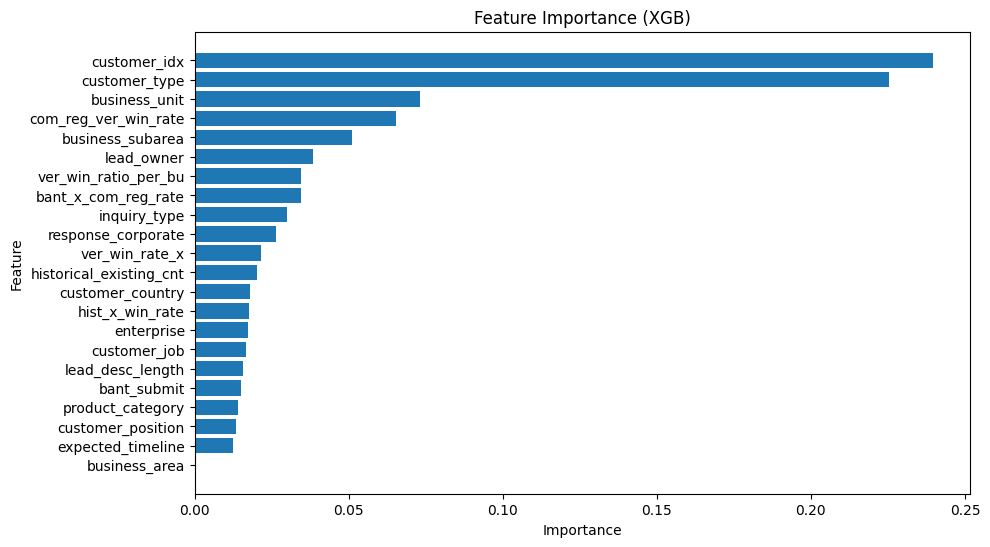

In [244]:
# Ensure your XGBoost model (xgb_model) is already defined and x_train, y_train are ready
xgb_model.fit(x_train, y_train)

# Extract feature importances from the fitted XGBoost model
feature_importances_xgb = xgb_model.feature_importances_

# Ensure features is defined as the column names from x_train
features = x_train.columns

# Create a DataFrame for feature importances for easy plotting
df_feature_importances_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_xgb
}).sort_values('Importance', ascending=False)

# Visualization using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances_xgb['Feature'], df_feature_importances_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGB)')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

[LightGBM] [Info] Number of positive: 3889, number of negative: 43550
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081979 -> initscore=-2.415758
[LightGBM] [Info] Start training from score -2.415758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

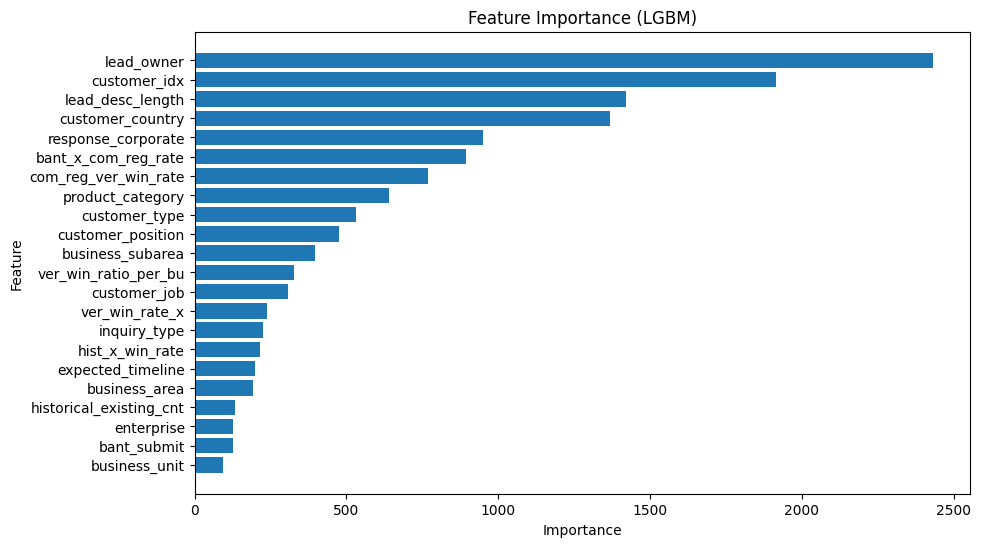

In [101]:
#lgbm 피처 중요도
lgbm_model.fit(x_train, y_train)

# Extract feature importances
feature_importances_lgbm = lgbm_model.feature_importances_
features = x_train.columns

# Create a DataFrame for feature importances
df_feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_lgbm
}).sort_values('Importance', ascending=False)

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (LGBM)')
plt.gca().invert_yaxis()
plt.show()

# 최적의 임계값 출력하기

In [189]:
train_csv = df_train.drop(["is_converted"], axis=1)

train_predict = ensemble_model.predict(train_csv)


#실제
actual_labels = df_train['is_converted']

# 맞는거 계산
correct_predictions = sum(actual_labels == train_predict)

print(f'{len(df_train)}개중에서 {correct_predictions}개 맞춤 ')

59299개중에서 53977개 맞춤 


In [155]:

x_test = df_test.drop(["is_converted", "id"], axis=1)

test_pred =ensemble_model.predict(x_test.fillna(0))

print("총 5271개의 데이터 중 True(영업전환 될 것이다)로 예상한 개수:", sum(test_pred)) 


총 5271개의 데이터 중 True(영업전환 될 것이다)로 예상한 개수: 2254


In [156]:

df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred
df_sub.to_csv("submission.csv", index=False)

